In [1]:
import pandas as pd
import numpy as np

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

## Exploratory Data Analysis

In [2]:
news_data = pd.read_csv("data/all_news.csv")
news_data['date'] = pd.to_datetime(news_data.date)
news_data

,date,title,url,source,topic
0,2021-08-12 20:00:24+00:00,Open Post: Hosted By Brendan Fraser Getting Em...,https://dlisted.com/2021/08/12/open-post-hoste...,NaN,Brendan Fraser
1,2021-08-12 14:45:00+00:00,"Sometimes, the Internet is Good: Brendan Frase...",https://www.pajiba.com/web_culture/sometimes-t...,NaN,Brendan Fraser
2,2021-08-12 17:30:38+00:00,10 Brilliant Martin Scorsese Movies to Buy on ...,https://www.indiewire.com/shop/best-martin-sco...,NaN,Brendan Fraser
3,2021-08-12 20:29:00+00:00,Watch: Brendan Fraser Gets Emotional in Respon...,https://comicbook.com/movies/news/brendan-fras...,NaN,Brendan Fraser
4,2021-08-12 21:05:00+00:00,GreenPower Reports Fiscal First Quarter 2022 F...,https://finance.yahoo.com/news/greenpower-repo...,NaN,Brendan Fraser
...,...,...,...,...,...
218002,2022-05-20 06:04:14+00:00,Chris Brown Subtly Congratulates Ex-Girlfriend...,https://www.tuko.co.ke/entertainment/celebriti...,Breaking NEWS in KENYA for Today Right Now & K...,Rihanna
218003,2022-05-20 09:23:35+00:00,"I’m Finally a Grandma: Kemi Olunloyo Declares,...",https://www.legit.ng/entertainment/celebrities...,Latest News in Nigeria & Breaking Naija News 2...,Rihanna
218004,2022-05-20 05:30:12+00:00,Don Jazzy Finally Breaks Silence As Rihanna We...,https://www.legit.ng/entertainment/celebrities...,Latest News in Nigeria & Breaking Naija News 2...,Rihanna
218005,2022-05-20 12:35:58+00:00,“I’m finally a grandma” – Kemi Olunloyo reacts...,https://www.kemifilani.ng/entertainment/im-fin...,Kemifilani.ng,Rihanna


In [3]:
period = news_data.date.iloc[-1] - news_data.date.iloc[0]
period

Timedelta('280 days 14:44:40')

In [4]:
news_data.topic.value_counts()

Manchester United                     2597
Real Madrid                           2283
Arsenal                               2106
Barcelona                             2089
Liverpool                             2044
                                      ... 
National Pretzel Day free pretzels       1
Carolina Gold rice                       1
Barcelona vs Mallorca                    1
Nantes vs PSG                            1
Susan Roces passed away                  1
Name: topic, Length: 3268, dtype: int64

## Picking Topic - Barcelona

In [5]:
barcelona_news = news_data.loc[news_data.topic == "Barcelona"].copy()
barcelona_news = barcelona_news.reset_index(drop=True)
barcelona_news

,date,title,url,source,topic
0,2021-08-16 15:41:47+00:00,Barcelona president Laporta says Spanish club ...,https://www.bbc.co.uk/sport/football/58235195,BBC News,Barcelona
1,2021-08-16 08:35:16+00:00,Football transfer rumours: Lacazette or Aubame...,https://amp.theguardian.com/football/2021/aug/...,The Guardian,Barcelona
2,2021-08-16 13:58:47+00:00,Barcelona president Laporta blames Bartomeu fo...,https://amp.theguardian.com/football/2021/aug/...,The Guardian,Barcelona
3,2021-08-16 12:52:00+00:00,UPDATE 1-Soccer-Barca can escape financial hol...,https://www.reuters.com/article/soccer-spain-b...,Reuters,Barcelona
4,2021-08-16 15:42:00+00:00,Soccer-Barca can escape financial hole in 18 m...,https://www.reuters.com/lifestyle/sports/socce...,Reuters,Barcelona
...,...,...,...,...,...
2084,2022-05-10 18:30:00+00:00,Global Operational Technology Market Report 20...,https://finance.yahoo.com/news/global-operatio...,Yahoo Entertainment,Barcelona
2085,2022-05-10 09:20:59+00:00,Football legend Ronaldinho to take fans on Par...,https://www.mirror.co.uk/sport/football/footba...,Mirror Online,Barcelona
2086,2022-05-10 14:16:48+00:00,Man Utd receive Darwin Nunez transfer boost fr...,https://www.mirror.co.uk/sport/football/transf...,Mirror Online,Barcelona
2087,2022-05-10 17:46:40+00:00,Jadon Sancho's Erling Haaland plea falls on de...,https://www.mirror.co.uk/sport/football/transf...,Mirror Online,Barcelona


## Getting Sentiment

In [6]:
def get_sent(row):
    docs = nlp(row["title"])
    tokens = [w.lower_ for w in docs if not (w.is_stop or w.is_punct)]
    processed_text = " ".join(tokens)
    
    text = nlp(processed_text)
    pol = text._.polarity
    return pol

In [7]:
barcelona_news["sentiment"] = barcelona_news.apply(lambda row: get_sent(row), axis=1)

In [8]:
barcelona_news.sentiment.describe()

count    2089.000000
mean        0.070759
std         0.242822
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.136364
max         1.000000
Name: sentiment, dtype: float64

## Exploring trends in sentiment

<AxesSubplot:xlabel='date'>

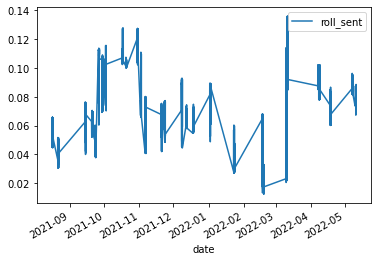

In [9]:
roll_df = barcelona_news.copy()
roll_df["roll_sent"] = barcelona_news.rolling(
        window=100, center=True, win_type="hamming"
    )["sentiment"].mean()
roll_df = roll_df.loc[roll_df.roll_sent.notnull()].reset_index(drop=True)
roll_df.plot(x='date', y='roll_sent')

<AxesSubplot:xlabel='date'>

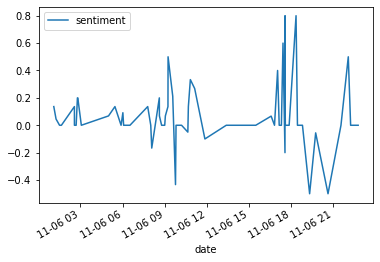

In [10]:
barcelona_news.iloc[900:960].plot(x="date", y="sentiment")

In [11]:
for row in barcelona_news.iloc[1390:1450].title:
    print(row, "\n")

Chelsea vs Tottenham prediction: How will Premier League fixture play out today? 

Nicolas Pepe provides Pierre-Emerick Aubameyang transfer update to plucky Arsenal fan 

Southampton’s early onslaught leaves City with peculiar feeling 

Bukayo Saka, Jadon Sancho and Marcus Rashford: Three lions on different paths 

The good, the bad and the apparently unhappy - Three lions now on different paths 

Welcome to the pleasure dome: In the beacon of Bekan, Connacht have a modern facility to be proud of 

Deportivo Alaves vs Barcelona LIVE Streaming La Liga 2021-22: How to Watch La Liga Online, TV Telecast 

Water cannon, tear gas used against anti-vaccine protests in Brussels Demonstrators from as far away as France and Germany marched in the latest round of protests. 

Water cannon, tear gas used against anti-vaccine protests in Brussels 

Comment on A month with HANA Express Edition and my NUC (part 1) by Prasad Diwadkar 

Spanish low-cost airline Vueling cancels Feb flights to Ukraine - R

## Exploring Articles with positive and negative sentiment

In [12]:
negative_sent = barcelona_news.loc[barcelona_news.sentiment < 0]
positive_sent = barcelona_news.loc[barcelona_news.sentiment > 0]

In [13]:
def search_text(df, word):
    filtered = df.loc[df.title.str.contains(word, case=False)]
    return filtered

In [14]:
def get_wordcloud(df):
    text = " ".join(i for i in df.title)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

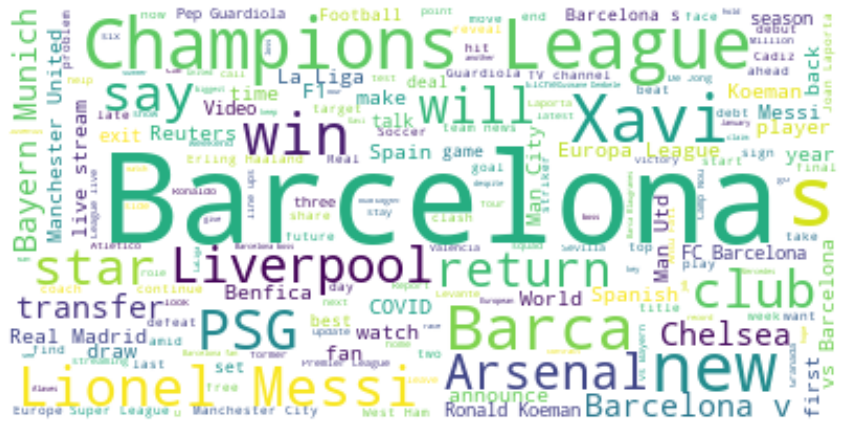

In [15]:
get_wordcloud(barcelona_news)

### Exploring Negative articles

negative sentiment


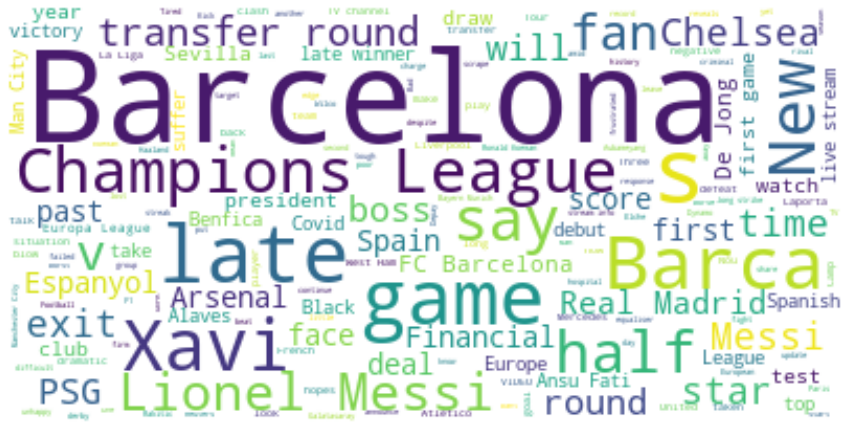

In [16]:
print("negative sentiment")
get_wordcloud(negative_sent)

In [17]:
for title in negative_sent.sort_values(by="sentiment").title:
    print(title, "\n")

Manchester City lack a ruthless streak and know Harry Kane can provide it 

Arsenal legend Robert Pires recounts Wenger fall-out and 'horrible week' which led to his exit 

Laporta: Barcelona's accounts are the worst in the club's history 

Manchester City lack a ruthless streak and know Harry Kane can provide it 

Barcelona star Ronald Araujo is taken to hospital after sickening clash of heads 

Araujo taken in ambulance after sickening clash of heads with Barcelona teammate Gavi 

‘Masturbation’ in the stands & trainers punching fans: Violent France is the shame of Europe 

Williams Is Setting Itself Up For A Painful Start To Formula 1’s Next Era 

West Ham frustrated as Burnley hold out for a point at Turf Moor 

Parquet Courts share “Marathon of Anger” video 

Barcelona 'eyeing up Leicester star Youri Tielemans' but will find it 'almost impossible' to buy him 

Police launch criminal hooliganism investigation after fans jump fence in stadium in bloody fight over flares during match

In [18]:
search_text(negative_sent, "messi")

,date,title,url,source,topic,sentiment
21,2021-08-16 13:43:48+00:00,‘The situation is dramatic’: More misery for B...,https://www.rt.com/sport/532177-barcelona-debt...,RT,Barcelona,-0.108333
28,2021-08-16 20:33:00+00:00,"Lionel Messi’s exit was “sad but necessary,” s...",https://www.barcablaugranes.com/2021/8/16/2262...,Barca Blaugranes,Barcelona,-0.250000
58,2021-08-16 13:12:29+00:00,Lionel Messi Paris Saint-Germain debut: When w...,https://www.cbssports.com/soccer/news/lionel-m...,CBS Sports,Barcelona,-0.200000
72,2021-08-16 03:10:41+00:00,"No Messi, No Problem As Barcelona Take ""Leap I...",https://sports.ndtv.com/football/la-liga-no-li...,NDTV News,Barcelona,-0.100000
99,2021-08-16 13:43:48+00:00,‘The situation is dramatic’: More misery for B...,https://www.rt.com/sport/532177-barcelona-debt...,RT,Barcelona,-0.108333
106,2021-08-16 20:33:00+00:00,"Lionel Messi’s exit was “sad but necessary,” s...",https://www.barcablaugranes.com/2021/8/16/2262...,Barca Blaugranes,Barcelona,-0.250000
136,2021-08-16 13:12:29+00:00,Lionel Messi Paris Saint-Germain debut: When w...,https://www.cbssports.com/soccer/news/lionel-m...,CBS Sports,Barcelona,-0.200000
150,2021-08-16 03:10:41+00:00,"No Messi, No Problem As Barcelona Take ""Leap I...",https://sports.ndtv.com/football/la-liga-no-li...,NDTV News,Barcelona,-0.100000
214,2021-08-21 12:25:05+00:00,Afghan Boy Also Known As Little Messi! The Tra...,https://www.indiatimes.com/news/sports/little-...,The Times of India,Barcelona,-0.468750
265,2021-09-14 08:05:56+00:00,Bayern Munich boss Julian Nagelsmann says Barc...,https://www.dailymail.co.uk/sport/football/art...,Daily Mail,Barcelona,-0.400000


In [29]:
search_text(negative_sent, "financial").iloc[0].title

'FC Barcelona’s Financial Woes Are Worse Than Originally Thought'

In [20]:
search_text(negative_sent, "xavi")

,date,title,url,source,topic,sentiment
442,2021-09-23 09:30:45+00:00,Xavi to Barcelona: A difficult deal... but not...,https://www.marca.com/en/football/barcelona/20...,Marca,Barcelona,-0.583333
948,2021-11-06 19:18:46+00:00,Xavi’s Barcelona task made yet more difficult ...,https://www.101greatgoals.com/news/xavis-barce...,101 Great Goals,Barcelona,-0.500000
969,2021-11-20 22:02:25+00:00,Barcelona 1-0 Espanyol: Xavi celebrates derby ...,https://www.bbc.co.uk/sport/football/59362787,BBC News,Barcelona,-0.400000
970,2021-11-20 16:31:50+00:00,Barcelona vs Espanyol live stream: How to watc...,https://www.independent.co.uk/sport/football/b...,Independent,Barcelona,-0.131818
973,2021-11-20 22:28:53+00:00,Barca edge past Espanyol to give Xavi debut vi...,https://worldsoccertalk.com/2021/11/20/barca-e...,Worldsoccertalk.com,Barcelona,-0.250000
979,2021-11-20 22:07:59+00:00,Barcelona 1-0 Espanyol: 5 things we noticed as...,https://www.mirror.co.uk/sport/football/news/b...,Mirror Online,Barcelona,-0.050000
985,2021-11-20 22:21:22+00:00,Barcelona 1-0 Espanyol: Xavi Xavi Hernandez be...,https://www.dailymail.co.uk/sport/football/art...,Daily Mail,Barcelona,-0.200000
1002,2021-11-20 16:37:47+00:00,Is Barcelona vs Espanyol on TV tonight? Kick-o...,https://www.independent.co.uk/sport/football/b...,Independent,Barcelona,-0.400000
1032,2021-11-23 21:53:28+00:00,Barcelona 0-0 Benfica: Xavi's side face tense ...,https://www.bbc.co.uk/sport/football/59393081,BBC News,Barcelona,-0.244444
1090,2021-11-23 11:13:09+00:00,Barcelona star Ansu Fati has his home 'BURGLED...,https://www.dailymail.co.uk/sport/sportsnews/a...,Daily Mail,Barcelona,-0.400000


In [28]:
search_text(negative_sent, "exit")

,date,title,url,source,topic,sentiment
21,2021-08-16 13:43:48+00:00,‘The situation is dramatic’: More misery for B...,https://www.rt.com/sport/532177-barcelona-debt...,RT,Barcelona,-0.108333
28,2021-08-16 20:33:00+00:00,"Lionel Messi’s exit was “sad but necessary,” s...",https://www.barcablaugranes.com/2021/8/16/2262...,Barca Blaugranes,Barcelona,-0.250000
99,2021-08-16 13:43:48+00:00,‘The situation is dramatic’: More misery for B...,https://www.rt.com/sport/532177-barcelona-debt...,RT,Barcelona,-0.108333
106,2021-08-16 20:33:00+00:00,"Lionel Messi’s exit was “sad but necessary,” s...",https://www.barcablaugranes.com/2021/8/16/2262...,Barca Blaugranes,Barcelona,-0.250000
225,2021-08-21 04:45:00+00:00,Arsenal transfer round-up: Gunners face Housse...,https://www.mirror.co.uk/sport/football/arsena...,Mirror Online,Barcelona,-0.200000
577,2021-09-29 13:50:56+00:00,Arsenal legend Robert Pires recounts Wenger fa...,https://www.dailymail.co.uk/sport/football/art...,Daily Mail,Barcelona,-1.000000
965,2021-11-06 03:00:00+00:00,Man City transfer round-up: Erling Haaland upd...,https://www.mirror.co.uk/sport/football/man-ci...,Mirror Online,Barcelona,-0.200000
1287,2021-12-18 05:15:00+00:00,Arsenal transfer round-up: Pierre-Emerick Auba...,https://www.mirror.co.uk/sport/football/arsena...,Mirror Online,Barcelona,-0.200000
1383,2022-01-23 19:26:41+00:00,Barcelona keen on Tagliafico as defender tries...,https://www.marca.com/en/football/barcelona/20...,Marca,Barcelona,-0.100000


### Exploring Positive articles

positive sentiment


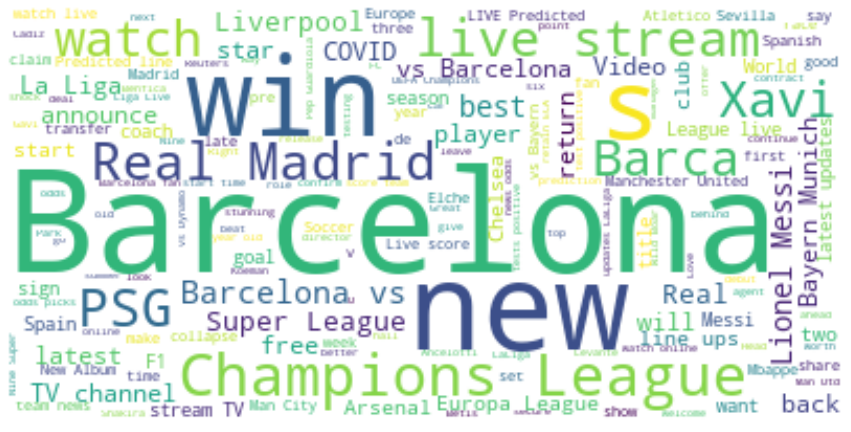

In [21]:
print("positive sentiment")
get_wordcloud(positive_sent)

In [22]:
search_text(positive_sent, "xavi")

,date,title,url,source,topic,sentiment
804,2021-10-30 16:37:27+00:00,Managerial debut date confirmed for Xavi as Ba...,https://www.101greatgoals.com/top-stories/xavi...,101 Great Goals,Barcelona,0.600000
820,2021-10-30 20:03:23+00:00,Xavi gets another win: Al Sadd victorious whil...,https://www.marca.com/en/football/internationa...,Marca,Barcelona,0.800000
903,2021-11-06 10:41:01+00:00,Barcelona confirm Xavi as new coach after Koem...,https://www.espn.in/football/barcelona-espbarc...,ESPN India,Barcelona,0.136364
904,2021-11-06 08:37:23+00:00,Barcelona finally announce Xavi is new first-t...,https://www.barcablaugranes.com/2021/11/6/2276...,Barca Blaugranes,Barcelona,0.068182
905,2021-11-06 01:06:21+00:00,'It Was Meant to Be': FC Barcelona Confirms Xa...,https://sputniknews.com/20211106/it-was-meant-...,Sputnik International,Barcelona,0.136364
908,2021-11-06 02:48:50+00:00,Barcelona hail return of ‘absolute legend’ Xav...,https://worldsoccertalk.com/2021/11/05/barcelo...,Worldsoccertalk.com,Barcelona,0.200000
913,2021-11-06 09:13:51+00:00,Five issues new Barcelona coach Xavi must address,https://worldsoccertalk.com/2021/11/06/five-is...,Worldsoccertalk.com,Barcelona,0.136364
919,2021-11-06 09:14:20+00:00,Barcelona: Xavi officially returns as head coa...,https://www.cbssports.com/soccer/news/barcelon...,CBS Sports,Barcelona,0.500000
920,2021-11-06 17:33:52+00:00,Barca welcome Xavi with three-goal collapse as...,https://worldsoccertalk.com/2021/11/06/barca-w...,Worldsoccertalk.com,Barcelona,0.800000
922,2021-11-06 22:03:53+00:00,"Barca welcome Xavi with three-goal collapse, R...",https://worldsoccertalk.com/2021/11/06/barca-w...,Worldsoccertalk.com,Barcelona,0.500000


In [23]:
search_text(positive_sent, "messi")

,date,title,url,source,topic,sentiment
16,2021-08-16 11:09:06+00:00,Messi’s Token Love Affair | Lesson From A $600...,https://www.forbes.com/sites/cryptoconfidentia...,Forbes,Barcelona,0.500000
94,2021-08-16 11:09:06+00:00,Messi’s Token Love Affair | Lesson From A $600...,https://www.forbes.com/sites/cryptoconfidentia...,Forbes,Barcelona,0.500000
166,2021-08-21 09:00:46+00:00,‘Who needs Messi?’ PSG maintain 100% start as ...,https://www.rt.com/sport/532701-gueye-goal-psg...,RT,Barcelona,0.043182
177,2021-08-21 20:03:06+00:00,Paris Saint-Germain newcomer Lionel Messi taps...,https://www.cbssports.com/soccer/news/paris-sa...,CBS Sports,Barcelona,0.068182
244,2021-09-14 14:18:00+00:00,The man to replace Messi? Russian boy wonder Z...,https://www.rt.com/sport/534797-zakharyan-barc...,RT,Barcelona,0.333333
267,2021-09-14 20:01:40+00:00,"PSG vs Club Brugge: Pochettino excited Messi, ...",https://punchng.com/psg-vs-club-brugge-pochett...,The Punch,Barcelona,0.375000
285,2021-09-14 18:55:11+00:00,"PSG boss Pochettino ‘excited’ to see Messi, Ne...",https://worldsoccertalk.com/2021/09/14/psg-bos...,Worldsoccertalk.com,Barcelona,0.375000
331,2021-09-20 13:18:06+00:00,Pochettino claims Messi told him he was ‘OK’ a...,https://www.rt.com/sport/535298-messi-psg-poch...,RT,Barcelona,0.500000
355,2021-09-20 21:05:30+00:00,Cristiano Ronaldo flying after returning 'home...,https://www.dailymail.co.uk/sport/football/art...,Daily Mail,Barcelona,0.136364
418,2021-09-23 16:00:00+00:00,Neymar takes on new role at PSG following Lion...,https://www.mirror.co.uk/sport/football/news/n...,Mirror Online,Barcelona,0.068182


In [53]:
search_text(positive_sent, "win").sort_values(by="sentiment", ascending=False)

,date,title,url,source,topic,sentiment
1065,2021-11-23 11:15:00+00:00,Holiday Gift Guide 2021: The Best Sparkling Wi...,https://www.forbes.com/sites/isabellekliger/20...,Forbes,Barcelona,1.000000
758,2021-10-20 21:26:21+00:00,UEFA Champions League: Juventus stays perfect;...,https://soccer.nbcsports.com/2021/10/20/uefa-c...,NBCSports.com,Barcelona,0.900000
1252,2021-12-18 10:00:29+00:00,Emma Raducanu favourite to win Sports Personal...,https://www.independent.co.uk/sport/emma-raduc...,Independent,Barcelona,0.850000
742,2021-10-20 18:54:55+00:00,Sergiño Dest impresses in wing role to help Ba...,https://sbisoccer.com/2021/10/sergino-dest-imp...,Sbisoccer.com,Barcelona,0.800000
612,2021-10-02 21:26:16+00:00,Atletico Madrid add to Barcelona’s woes while ...,https://www.independent.co.uk/sport/football/a...,Independent,Barcelona,0.800000
...,...,...,...,...,...,...
418,2021-09-23 16:00:00+00:00,Neymar takes on new role at PSG following Lion...,https://www.mirror.co.uk/sport/football/news/n...,Mirror Online,Barcelona,0.068182
1706,2022-03-11 03:53:11+00:00,'Not impossible' for resurgent Barcelona to wi...,https://timesofindia.indiatimes.com/sports/foo...,The Times of India,Barcelona,0.066667
575,2021-09-29 11:53:14+00:00,Were does Sheriff's win at Real Madrid rank in...,https://www.dailymail.co.uk/sport/football/art...,Daily Mail,Barcelona,0.066667
595,2021-10-02 20:55:14+00:00,Barcelona fans send crystal clear message to J...,https://www.101greatgoals.com/news/barcelona-f...,101 Great Goals,Barcelona,0.050000


In [54]:
search_text(positive_sent, "new").sort_values(by="sentiment", ascending=False)

,date,title,url,source,topic,sentiment
1387,2022-01-23 22:31:16+00:00,Barcelona player ratings vs Alaves: Pedri's re...,https://www.marca.com/en/football/barcelona/20...,Marca,Barcelona,0.700000
1975,2022-05-07 06:30:00+00:00,"Man Utd, Liverpool and Newcastle could take ad...",https://www.mirror.co.uk/sport/football/transf...,Mirror Online,Barcelona,0.400000
12,2021-08-16 11:57:57+00:00,Christophe Galtier’s new-look Nice leave Ligue...,https://amp.theguardian.com/football/2021/aug/...,The Guardian,Barcelona,0.368182
90,2021-08-16 11:57:57+00:00,Christophe Galtier’s new-look Nice leave Ligue...,https://amp.theguardian.com/football/2021/aug/...,The Guardian,Barcelona,0.368182
1673,2022-03-11 01:00:00+00:00,Arsenal news: Gunners told to keep 'vitally im...,https://www.mirror.co.uk/sport/football/news/a...,Mirror Online,Barcelona,0.350000
...,...,...,...,...,...,...
412,2021-09-23 16:45:13+00:00,Potential new contract issues for duo & intern...,https://www.thisisanfield.com/2021/09/potentia...,This Is Anfield,Barcelona,0.045455
166,2021-08-21 09:00:46+00:00,‘Who needs Messi?’ PSG maintain 100% start as ...,https://www.rt.com/sport/532701-gueye-goal-psg...,RT,Barcelona,0.043182
1853,2022-04-08 15:18:49+00:00,Watch Ville Valo romancing a sheep in the vide...,https://www.loudersound.com/news/ville-valo-lo...,Louder,Barcelona,0.032468
1443,2022-02-17 05:00:30+00:00,"HEALTH detail new collabs LP, share Lamb of Go...",https://www.brooklynvegan.com/health-detail-ne...,Brooklyn Vegan,Barcelona,0.032468
